In [1]:
import sys
#%cd variational_inference_for_longitudinal_data/
sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
sys.path.append('lib/src/')
import torch
from torch import nn
import torch.nn.functional as F
import os
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import logging




from diffusion.stable_diffusion.latent_diffusion import MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.unet import UNetModel
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

from lib.src.pythae.models import VAE
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.models import LLDM_IAF, LVAE_IAF_Config
from lib.src.pythae.trainers import BaseTrainerConfig, BaseTrainer
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs
from lib.scripts.utils import My_MaskedDataset, make_batched_masks
from lib.src.pythae.trainers.training_callbacks import WandbCallback

from geometric_perspective_on_vaes.sampling import hmc_sampling


def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )


def plot_sequence(X):

    if len(X.shape) == 4:
        X = X.unsqueeze(0)

    X = X.cpu().detach().numpy()
    num_seq = X.shape[0]
    num_obs = X.shape[1]

    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    plt.figure(figsize=(10, 10))
    for i in range(num_seq):
        for j in range(num_obs):
            plt.subplot(num_seq, num_obs, i*num_obs+j+1)
            plt.imshow(X[i, j].transpose(1, 2, 0))
            plt.axis('off')

    plt.show()
    logger.setLevel(old_level)


%reload_ext autoreload
%autoreload 2

!nvidia-smi

Sun Jul 21 18:43:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.100                Driver Version: 550.100        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0 Off |                  Off |
| 30%   42C    P8             10W /   70W |     119MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
PATH_DATA = 'lib/my_data/sprites/Sprites_train.pt'


train_data = torch.load(os.path.join(PATH_DATA))[:-1000, :-1, :, :, :]
eval_data = torch.load(os.path.join(PATH_DATA), map_location="cpu")[-1000:, :-1, :, :, :]
#test_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_test.pt'), map_location="cpu")

print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3)
eval_data = eval_data.permute(0, 1, 4, 2, 3)
#test_data = test_data.permute(0, 1, 4, 2, 3)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool)
#test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool)
#test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
#test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=200, shuffle=True)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=200, shuffle=True)

torch.Size([8000, 7, 64, 64, 3])
torch.Size([8000, 7, 3, 64, 64])


In [3]:
# encoder = Encoder_Chairs(config)
# decoder = Decoder_Chairs(config)
# vae = LVAE_IAF(config, encoder, decoder)


PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-06-16_15-12-03/final_model'
PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_12/checkpoints/epoch=49-step=1600.ckpt'


# Avec prior 'allongée' mais pas décalée
# PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-06-27_11-46-10/final_model'
# PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_7/checkpoints/epoch=49-step=1600.ckpt'


# Prior décalée
# PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-07-01_16-05-18/final_model'
# PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_15/checkpoints/epoch=49-step=1600.ckpt'

device = 'cuda'
vae = VAE.load_from_folder(PATH_VAE_FOLDER).to(device)
vae.eval()
_, _, _ = vae.retrieveG(train_data, verbose = True, T_multiplier=5, device = device, addStdNorm=True)


# in_channels = 3
# out_channels = 3
# channels = 32
# n_res_blocks = 2
# attention_levels = [2]
# channel_multipliers = (1, 2, 4)
# n_heads = 16


in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

latent_scaling_factor = 1
n_steps = 1000

#Pas oublier de modif
linear_start =  0.00085
linear_end = 0.012

input_dim = (3, 64, 64)
f = 32 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)


latent_diffusion = MyLatentDiffusion(unet, latent_scaling_factor, latent_dim, n_steps, linear_start, linear_end)
print('Number of parameters in the diffusion model: ', sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

model = LitLDM.load_from_checkpoint(PATH_DIFFUSION_CKPT, ldm = latent_diffusion, vae = vae, latent_dim = latent_dim, lr = 6e-4).to(device)
diffusion = model.ldm

Running Kmedoids


/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 74 is empty! self.labels_[self.medoid_indices_[74]] may not be labeled with its corresponding cluster (74).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 82 is empty! self.labels_[self.medoid_indices_[82]] may not be labeled with its corresponding cluster (82).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 84 is empty! self.labels_[self.medoid_indices_[84]] may not be labeled with its corresponding cluster (84).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 106 is empty! self.labels_[self.medoid_indices_[106]] may not be 

Finding temperature
Best temperature found:  2.6089720726013184
Building metric
Increasing T by  5
Adding std normal to centroids and var
Latent dim: 12
Number of parameters in the diffusion model:  2223043


In [4]:
model_config = LVAE_IAF_Config(
    input_dim=(3, 64, 64),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites, 7 as we remove last obs
    latent_dim=latent_dim,
    beta=0.2,
    n_hidden_in_made=2,
    n_made_blocks=4,
    warmup=0,
    context_dim=None,
    prior='standard',
    posterior='gaussian',
    linear_scheduling_steps=10,

)
training_config = BaseTrainerConfig(
        num_epochs=100,
        learning_rate=1e-4,
        batch_size=256,
        steps_saving=50,
        steps_predict=100,
        shuffle=True,
        output_dir='lldm'
    )


device = 'cuda'
encoder = Encoder_Chairs(model_config).to(device)
decoder = Decoder_Chairs(model_config).to(device)
ddim_sampler = DDIMSampler(diffusion, n_steps = train_data.shape[1]-1, ddim_eta = 1)
zT_samples = torch.load('zT_samples.pt') #shape (1000, 12)
temperature = 1


#############
# lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
#                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
#                 precomputed_zT_samples=zT_samples, GM = GM, verbose = True)

lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
                 precomputed_zT_samples=zT_samples, verbose = True, temp = temperature)

Diffusion time steps  [997 831 665 499 333 167   1]
Running on  cuda:0
Freezing pre-trained VAE and pre-trained LDM...
Freezing done.
Number of trainable parameters: 1.1e+06
Number of total parameters: 4.4e+06


/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


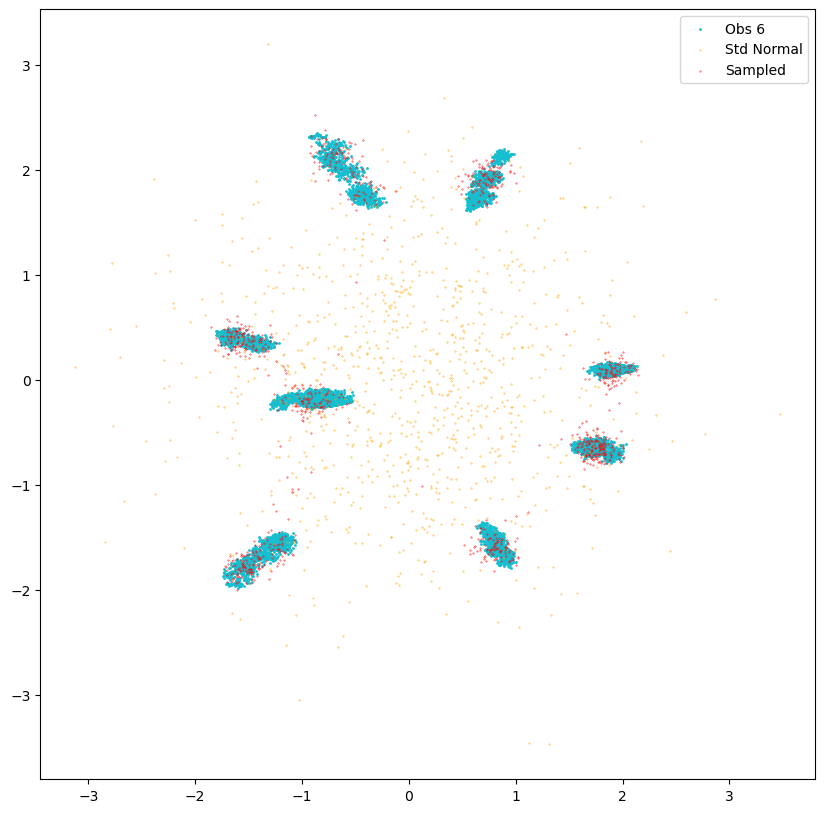

In [5]:
from sklearn.decomposition import PCA

#########
NUM_OBS = 7
DISPLAYED_OBS =  [6]
PROJECTING_OBS = [6]
NUM_POINTS = 1000
#########

train_embeddings = vae.encoder.to('cpu')(train_dataset.data).embedding
pca = PCA(n_components=2)
indices = [k % NUM_OBS in PROJECTING_OBS for k in range(train_dataset.data.shape[0]*train_dataset.data.shape[1])]
projection_embeddings = train_embeddings[indices].detach().numpy()
pca.fit(projection_embeddings)

train_pca = pca.transform(train_embeddings.detach().numpy())

#all_z_pca = pca.transform(all_z.cpu().detach().numpy())
#p_pca  = pca.transform(p.cpu().detach().numpy())
colors = plt.get_cmap('tab10', NUM_OBS)




plt.figure(figsize=(10, 10))
for i in DISPLAYED_OBS:
    indices = [k % NUM_OBS == i for k in range(train_embeddings.shape[0])]
    plt.scatter(train_pca[indices, 0], train_pca[indices, 1], label=f'Obs {i}', s= 1, color = colors(i))


check = torch.randn(NUM_POINTS, 12)
check_pca = pca.transform(check.detach().numpy())

start = check.reshape(NUM_POINTS, model.c, model.h, model.w).cuda()
sampled, _, _ = lldm.ddim_sampler.sample(shape=(NUM_POINTS, model.c, model.h, model.w), x_last = start, cond=None, temperature= lldm.temperature)
sampled = sampled.reshape(NUM_POINTS, lldm.latent_dim)
sampled_pca = pca.transform(sampled.cpu().detach().numpy())

plt.scatter(check_pca[:, 0], check_pca[:, 1], s = 0.1, label='Std Normal', c = 'orange')
plt.scatter(sampled_pca[:, 0], sampled_pca[:, 1], s = 0.1, label='Sampled', c = 'red')


plt.legend()
plt.show()

In [24]:
callbacks = [] # the TrainingPipeline expects a list of callbacks
wandb_cb = WandbCallback() # Build the callback 
# SetUp the callback 
wandb_cb.setup(
    training_config=training_config, # pass the training config
    model_config = model_config,
    project_name="LLDM_reborn", # specify your wandb project # specify your wandb entity
)
callbacks.append(wandb_cb) 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: meilame-tayebjee. Use `wandb login --relogin` to force relogin


In [31]:
optimizer = torch.optim.Adam(lldm.parameters(), lr=1e-3)

### Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, verbose=True)
trainer = BaseTrainer(
            model=lldm,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            training_config=training_config,
            optimizer=optimizer,
            scheduler=scheduler,
            #callbacks=callbacks
        )

In [ ]:
for p in lldm.parameters():
    p.requires_grad = True
for p in lldm.pretrained_vae.parameters():
    p.requires_grad = False
for p in lldm.pretrained_ldm.parameters():
    p.requires_grad = False
trainer.train()

In [6]:
#lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-07-02_14-46-51/final_model/model.pt')['model_state_dict'])
lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-07-02_18-30-00/final_model/model.pt')['model_state_dict'])

<All keys matched successfully>

In [24]:
model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
new_vae = VAE(model_config = model_config, encoder = lldm.encoder, decoder = lldm.decoder)
model = LitLDM.load_from_checkpoint('ldm_retrain/lightning_logs/version_3/checkpoints/epoch=99-step=3200.ckpt', ldm = latent_diffusion, vae = new_vae, latent_dim = latent_dim).to('cuda')
lldm.pretrained_ldm = model.ldm

for p in lldm.pretrained_ldm.parameters():
    p.requires_grad = False

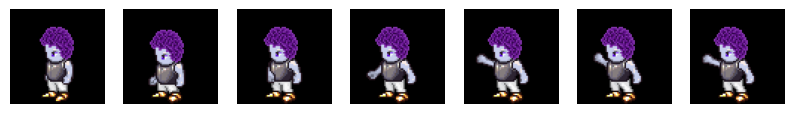

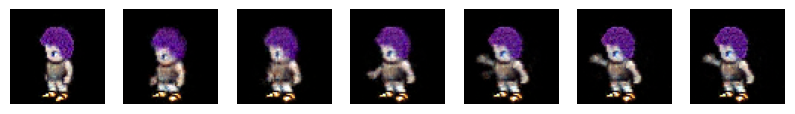

Reconstruction loss: 36.250709533691406


In [7]:
### TESTING RECONSTRUCTION ###
lldm = lldm.to('cuda')
lldm = lldm.eval()
#x = train_data[0].to('cuda').unsqueeze(0)


# z = lldm.encoder(x).embedding[0]
# _, z, _ = lldm.ddim_sampler.sample(shape = (1 , 3, 2, 2), x_last = z.reshape(1,3,2,2), cond = None)


# z = z.reshape(8,  12)
# x_rec = lldm.decoder(z).reconstruction

idx = torch.randint(0, len(train_dataset), (1,)).item()
x = train_dataset[idx]
z_seq, x_rec = lldm.reconstruct(x, vi_index = 0)

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec)

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


In [8]:
train_embeddings = [] 
log_vars = []

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
for i, x in enumerate(train_loader):
    x = x.to('cuda')
    out = lldm.encoder(x)
    z = out.embedding.reshape(-1, 7, 12)
    log_var = out.log_covariance
    train_embeddings.append(z.cpu().detach())
    log_vars.append(log_var.cpu().detach())
train_embeddings = torch.stack(train_embeddings).squeeze(1)
print(train_embeddings.shape)

torch.Size([8000, 7, 12])


PCA on the whole dataset (56000 data points)


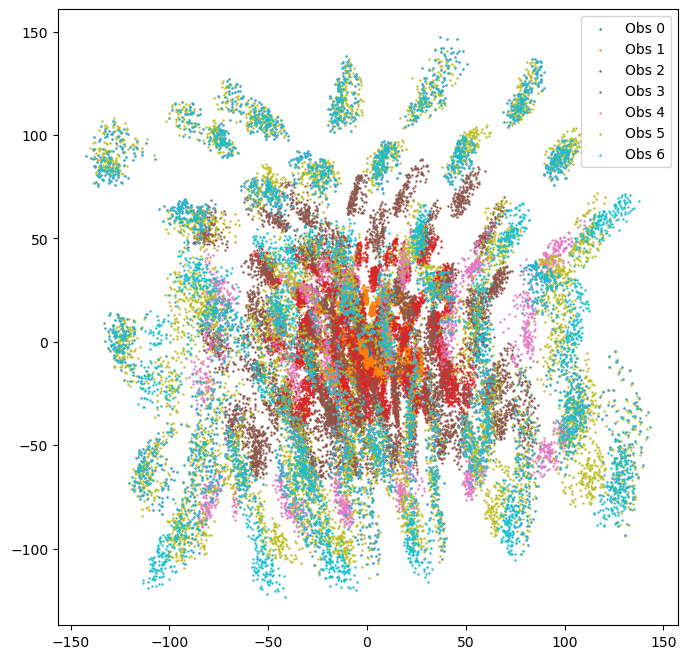

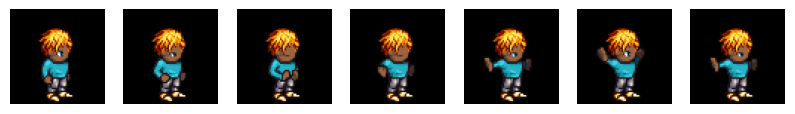

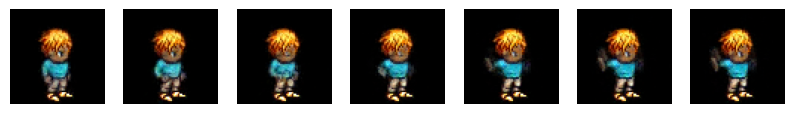

Reconstruction loss: 15.01756477355957


In [23]:
pca = PCA(n_components=2)
num_obs = train_embeddings.shape[1]
lldm = lldm.to('cuda')
#torch.manual_seed(46)

###################
vi_index = 0
projection_index = 'all' # 'all', 'pre
displayed_indexes = range(num_obs)  #range(num_obs)
train_point = 116
##################


if projection_index == 'all':
    gathered = train_embeddings.reshape(-1, latent_dim)
    pca.fit(gathered)
    print(f'PCA on the whole dataset ({gathered.shape[0]} data points)')
elif projection_index == 'pre':
    last_preembed = torch.load('preembedding-last.pt')
    #last_preembed = torch.load('pre-embeddings2.pt')
    #last_preembed = torch.load('pre-embeddings-priordecalee.pt')
    pca.fit(last_preembed)
else:
    pca.fit(train_embeddings[:, projection_index, :].reshape(-1, latent_dim))

train_embeddings_pca = []
for i in range(num_obs):
    train_embeddings_pca.append(pca.transform(train_embeddings[:, i, :].reshape(-1, latent_dim)))

train_embeddings_pca = np.stack(train_embeddings_pca).transpose(1, 0, 2)



plt.figure(figsize=(8, 8))
colors = plt.get_cmap('tab10', num_obs)
for i in displayed_indexes:
    plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Obs {i}')

x = train_dataset[train_point]

z_seq, x_rec = lldm.reconstruct(x, vi_index = vi_index)

# sampler = lldm.ddim_sampler
# start = train_embeddings[train_point, vi_index, :].cuda().reshape(1, model.c, model.h, model.w)
# _, z_seq, _ = sampler.sample(shape=(1, model.c, model.h, model.w), x_last = start, cond=None)
# z_seq = z_seq[:-1].reshape(-1, latent_dim)
# x_rec = lldm.decoder(z_seq).reconstruction


z_seq_pca = pca.transform(z_seq.cpu().detach())

colors = plt.get_cmap('Spectral', 7)
# for i in range(num_obs):
#     plt.scatter(z_seq_pca[i, 0], z_seq_pca[i, 1], s=20, color=colors(i), label=f'Point {i}')


plt.legend()
plt.show()

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec)

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


In [10]:
model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
new_vae = VAE(model_config = model_config, encoder = lldm.encoder, decoder = lldm.decoder)

last_train_data = train_data[:, -1]
last_eval_data = eval_data[:, -1]


BATCH_SIZE = 256

last_train_loader = torch.utils.data.DataLoader(last_train_data, batch_size=BATCH_SIZE, num_workers = 12)
last_val_loader = torch.utils.data.DataLoader(last_eval_data, batch_size=800, num_workers = 12)


In [ ]:
import lightning as L
ldm = lldm.pretrained_ldm

#UNFREEZE LDM
for p in ldm.parameters():
    p.requires_grad = True


n_steps = 1000
linear_start =  0.00085
linear_end = 0.012
latent_scaling_factor = 1
lr = 1e-3
MAX_EPOCHS = 100


model = LitLDM(ldm = ldm, vae = new_vae, lr = lr).to(device)




trainer = L.Trainer(max_epochs=MAX_EPOCHS,
                     default_root_dir='ldm_retrain', accelerator = 'gpu', 
                     check_val_every_n_epoch=5)



trainer.fit(model, last_train_loader, last_val_loader)

#REFREEZE LDM
for p in ldm.parameters():
    p.requires_grad = False

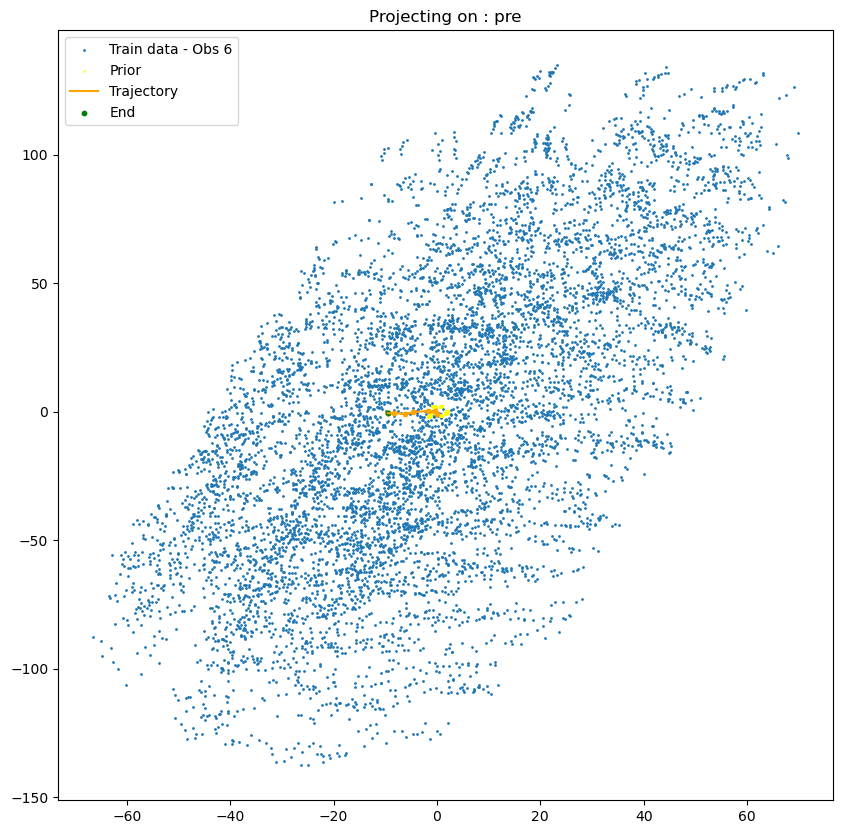

In [18]:
sampler = lldm.ddim_sampler
lldm = lldm.to('cuda')
lldm.eval()

######################
check_index = 6 #6
start = 'normal' #'embedding'
######################

assert check_index == 6 or check_index == 0
assert start == 'normal' or start == 'embedding'
if check_index == 0:
    check = np.random.randn(10000, model.lat_dim)
if check_index == 6:
    check = last_preembed


check_pca = pca.transform(check)

if start == 'normal':
    start = torch.randn(1, model.c, model.h, model.w).to('cuda')
if start == 'embedding':
    start = train_embeddings[train_point, 0, :].reshape(1, model.c, model.h, model.w).to('cuda')

z, all_z, all_pred_z0 = sampler.sample(shape=(1, model.c, model.h, model.w), x_last = start, cond=None)

z = z.reshape(-1, latent_dim).float()
x = vae.decoder(z).reconstruction.reshape(-1, 3, 64, 64)


all_z = all_z.squeeze(1).reshape(-1, latent_dim)

all_x = vae.decoder(all_z).reconstruction.reshape(-1, 3, 64, 64)

start = start.reshape(-1, latent_dim).float()



all_z_pca = pca.transform(all_z.detach().cpu().numpy())
start_pca = pca.transform(start.detach().cpu().numpy())
z_pca = pca.transform(z.detach().cpu().numpy())
plt.figure(figsize=(10, 10))
plt.scatter(train_embeddings_pca[:, check_index, 0], train_embeddings_pca[:, check_index, 1], label=f'Train data - Obs {check_index}', s= 1)
plt.scatter(check_pca[:, 0], check_pca[:, 1], label='Prior', s= 0.5, c = 'yellow')

old = torch.load('preembedding-last.pt')
#old = torch.load('pre-embeddings-priordecalee.pt')
old_pca  = pca.transform(old)

#plt.scatter(old_pca[:, 0], old_pca[:, 1], label='Previous Obs 6 embed.', s= 0.5, c = 'red')


plt.plot(all_z_pca[:, 0], all_z_pca[:, 1], label='Trajectory', c = 'orange')
plt.scatter(all_z_pca[:, 0], all_z_pca[:, 1], c = 'orange', s=10)
plt.scatter(z_pca[:, 0], z_pca[:, 1], s=10, label = "End", c = 'green')
plt.legend()
plt.title('Projecting on : ' + str(projection_index))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


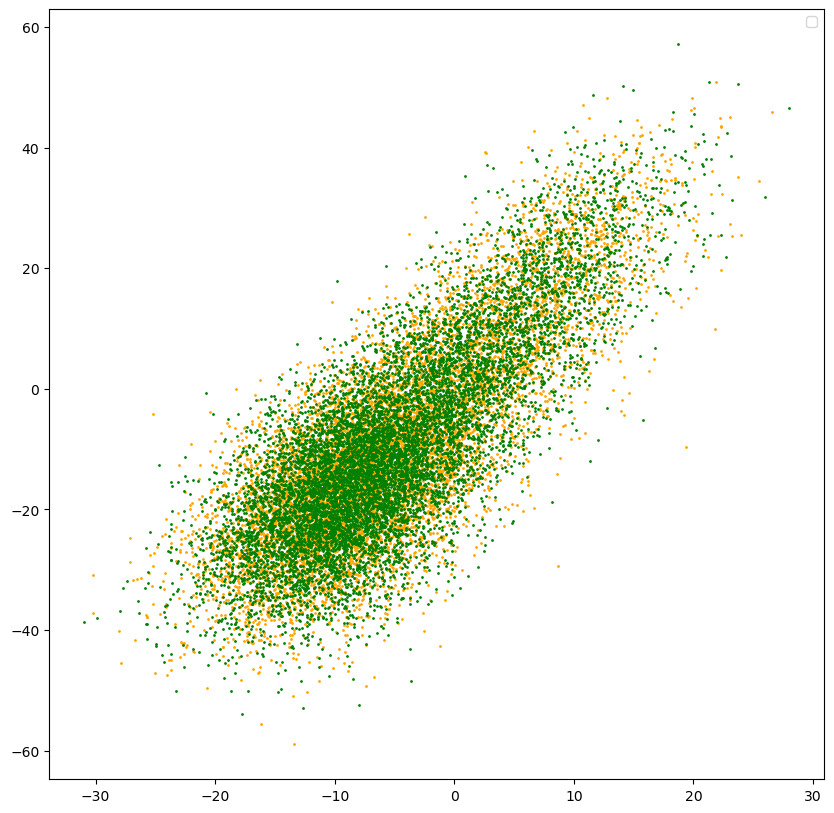

In [19]:
NUM_POINTS = 10000

INDEX = -1

sampler = lldm.ddim_sampler
z = torch.randn(NUM_POINTS, latent_dim).to('cuda')

_, final_z_1, _ = sampler.sample(shape = (NUM_POINTS, 3, 2, 2), x_last = z.reshape(NUM_POINTS, 3, 2, 2), cond = None)
final_z_1  = final_z_1[INDEX, :, :, :, :].reshape(-1, latent_dim)

z_vi_index = z
z_seq = [z_vi_index]

z_for = z_vi_index
batch_size = z_for.shape[0]
vi_index = 0
for i in range(vi_index, lldm.n_obs - 1):
    t = torch.tensor(lldm.diff_t_steps[i]).reshape(1).to(lldm.pretrained_ldm.device).float() #diffusion time-step
    z_for = z_for.reshape(batch_size, lldm.pretrained_ldm.c, lldm.pretrained_ldm.h, lldm.pretrained_ldm.w).float().to(lldm.pretrained_ldm.device)
    noise_pred = lldm.pretrained_ldm(z_for, t) # \eps_\theta (z_t, t)
    z_for, _ = sampler.get_x_prev_and_pred_x0(e_t = noise_pred,
                                                        index = lldm.n_obs -1- i,
                                                        x = z_for,
                                                        temperature=lldm.temperature,
                                                        repeat_noise=False)
    
    z_for = z_for.reshape(batch_size, lldm.pretrained_ldm.c * lldm.pretrained_ldm.h * lldm.pretrained_ldm.w).to(lldm.pretrained_ldm.device)
    z_seq.append(z_for)



z_seq = torch.stack(z_seq, dim = 1)

final_z_2 = z_seq[:, INDEX, :].reshape(-1, latent_dim)

z_pca = pca.transform(z.detach().cpu().numpy())
final_z_pca = pca.transform(final_z_1.detach().cpu().numpy())
final_z_pca_2 = pca.transform(final_z_2.detach().cpu().numpy())

plt.figure(figsize=(10, 10))
#plt.scatter(z_pca[:, 0], z_pca[:, 1], label='Prior', s= 0.5, c = 'yellow')

plt.scatter(final_z_pca[:, 0], final_z_pca[:, 1], c = 'orange', s=1)
plt.scatter(final_z_pca_2[:, 0], final_z_pca_2[: ,1], c = 'green', s=1)
#plt.scatter(check_pca[:, 0], check_pca[:, 1], label='Prior', s= 1, c = 'yellow')
plt.legend()

In [20]:
model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
final_vae = VAE(model_config = model_config, encoder = lldm.encoder, decoder = lldm.decoder)
obs_data = train_data[:, 0]
_, mu, log_var = final_vae.retrieveG(obs_data, verbose = True, T_multiplier=0.5, device = 'cuda', addStdNorm=False)






Running Kmedoids
Finding temperature
Best temperature found:  8.50917911529541
Building metric
Increasing T by  0.5


In [28]:
n_samples = 10
batch_size = 10
all_z0 = []

device = 'cpu'
final_vae = final_vae.to(device)
mu = mu.to(device)
for j in range(0, int(n_samples / batch_size)):
    z, p = hmc_sampling(final_vae, mu, n_samples=batch_size, mcmc_steps_nbr=100)
    all_z0.append(z)

p = p[0]
all_z0 = torch.cat(all_z0, dim=0).cpu().detach()
all_z0.shape

torch.Size([10, 12])

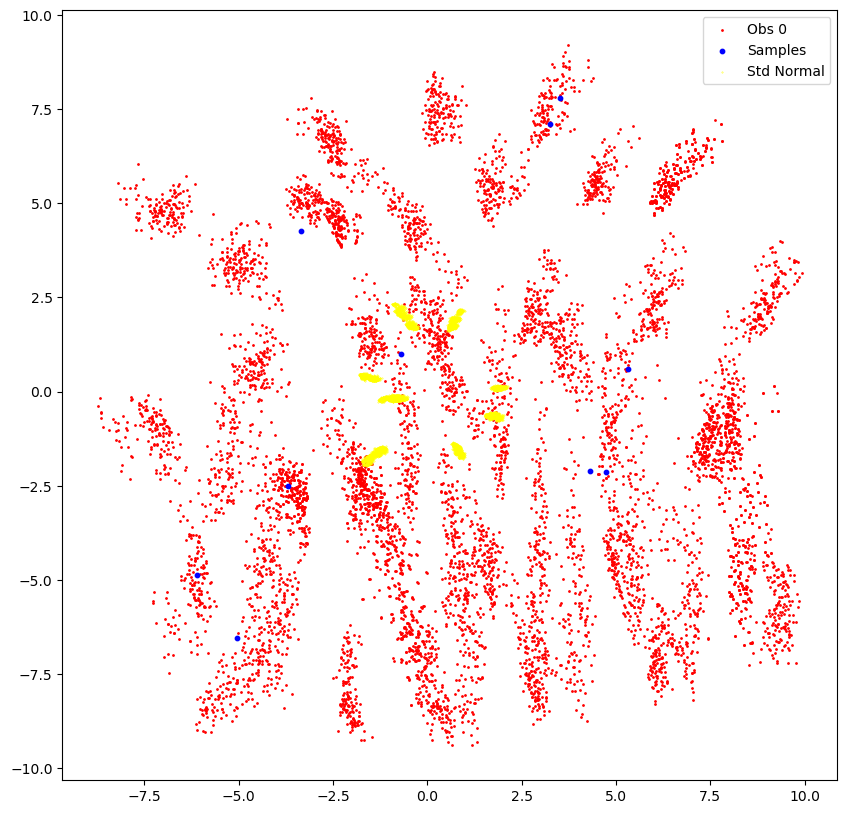

In [29]:
final_vae = final_vae.to(obs_data.device)
obs_manifold = final_vae.encoder(obs_data).embedding.cpu().detach().numpy()
obs_manifold_pca = pca.transform(obs_manifold.reshape(-1, latent_dim))
all_z0_pca = pca.transform(all_z0.cpu().detach().numpy())
plt.figure(figsize=(10, 10))
plt.scatter(obs_manifold_pca[:, 0], obs_manifold_pca[:, 1], label='Obs 0', s= 1, c = 'red')
plt.scatter(all_z0_pca[:, 0], all_z0_pca[:, 1], label='Samples', s= 10, c = 'blue')
plt.scatter(check_pca[:, 0], check_pca[:, 1], label='Std Normal', s= 0.1, c = 'yellow')
plt.legend()
plt.show()

In [30]:
all_z0 = all_z0.to('cuda')
NUM_OBS = train_data.shape[1]
all_sequences = lldm.ddim_sampler.sample(shape=(all_z0.shape[0], model.c, model.h, model.w), x_last = all_z0.reshape(-1, model.c, model.h, model.w), temperature = 1)[1]
all_sequences = all_sequences[:-1].transpose(0, 1).reshape(all_z0.shape[0], NUM_OBS, latent_dim).cpu()
all_sequences.shape

torch.Size([10, 7, 12])

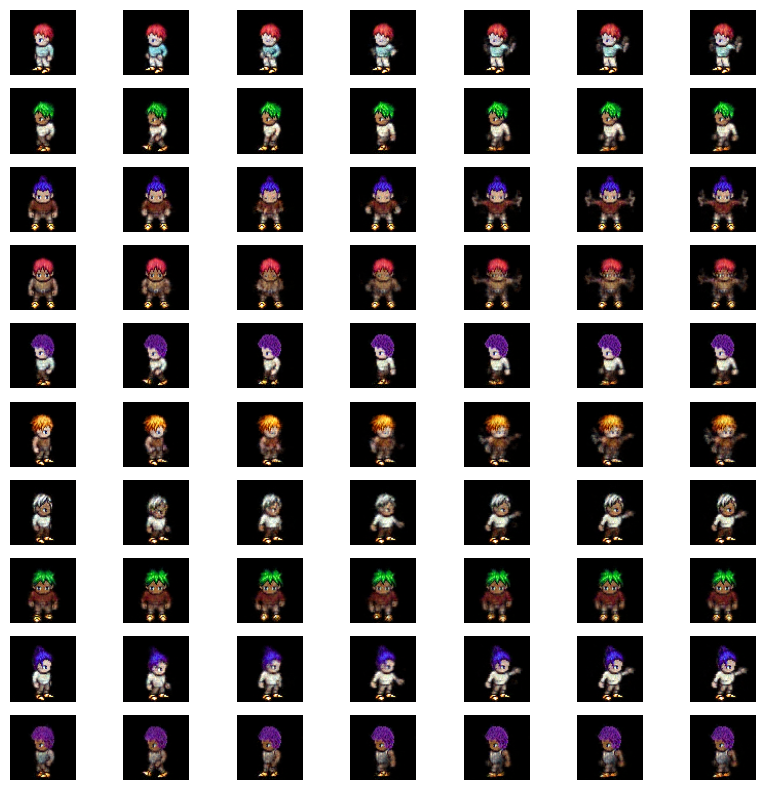

In [31]:
recon = final_vae.decoder(all_sequences.reshape(-1, latent_dim)).reconstruction.reshape(-1, NUM_OBS, 3, 64, 64)
plot_sequence(recon)

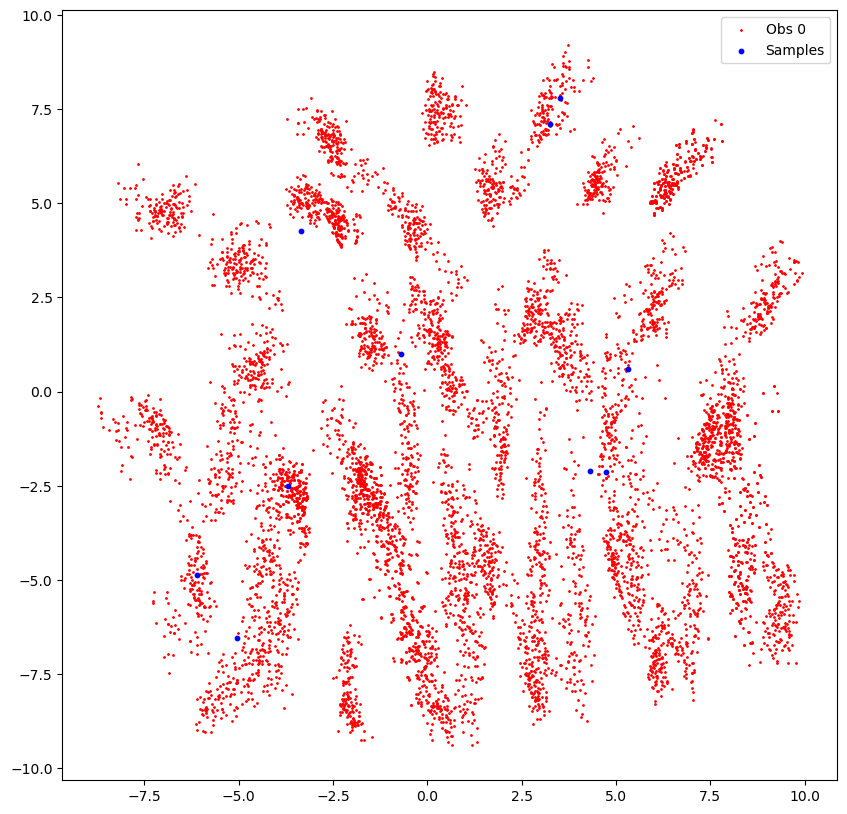

In [32]:
obs_manifold = final_vae.encoder(obs_data).embedding.cpu().detach().numpy()
obs_manifold_pca = pca.transform(obs_manifold.reshape(-1, latent_dim))
all_z0_pca = pca.transform(all_z0.cpu().detach().numpy())
plt.figure(figsize=(10, 10))
plt.scatter(obs_manifold_pca[:, 0], obs_manifold_pca[:, 1], label='Obs 0', s= 1, c = 'red')
plt.scatter(all_z0_pca[:, 0], all_z0_pca[:, 1], label='Samples', s= 10, c = 'blue')
plt.legend()
plt.show()

Running Kmedoids
Finding temperature
Best temperature found:  120.40079498291016
Building metric
Increasing T by  0.5
Sampling on the 4th/rd manifold...
Propagating in the past...
Propagating in the future...
Decoding...


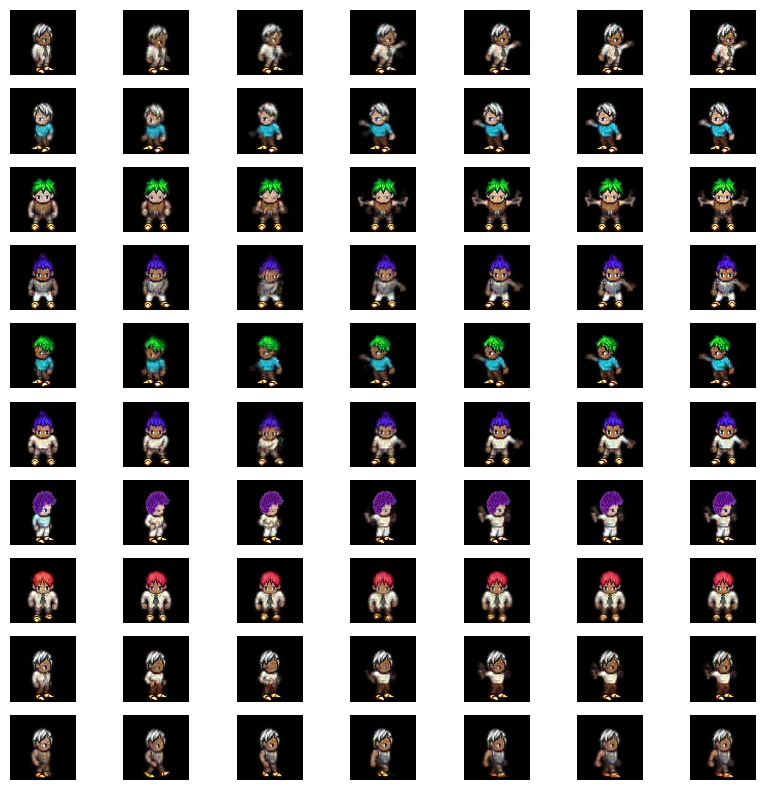

In [34]:
recon_x, z_seq = lldm.generate(train_data, num_gen_seq=10, vi_index = 4)
plot_sequence(recon_x)

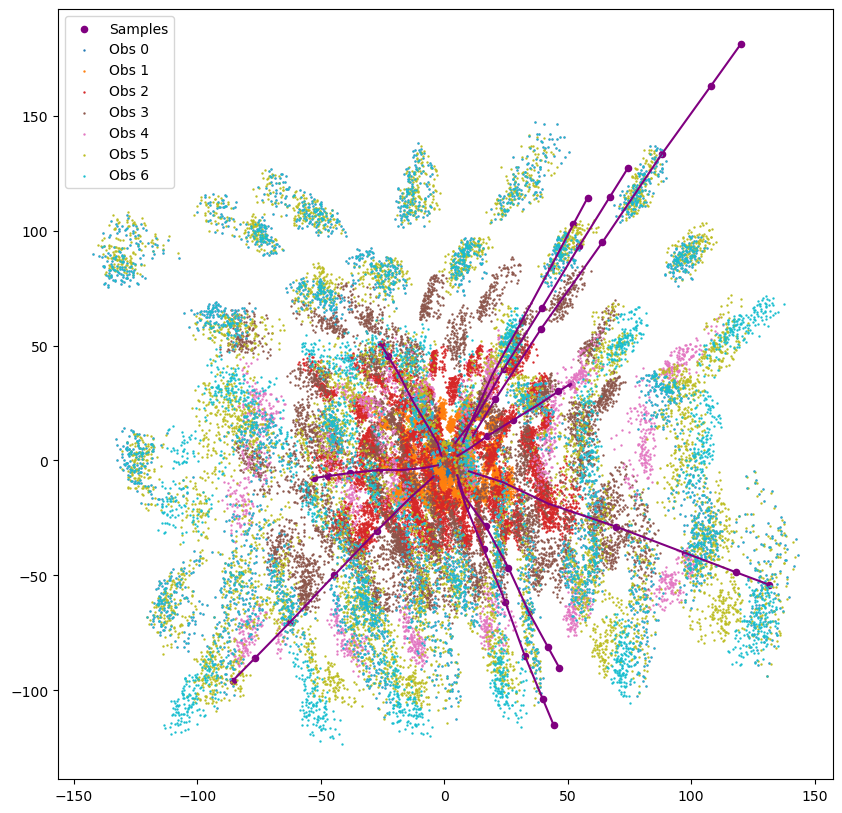

In [35]:
displayed_indexes = range(num_obs)  #range(num_obs)

all_sequences = z_seq
all_sequences_pca = pca.transform(all_sequences.reshape(-1, latent_dim).cpu().detach().numpy())
all_sequences_pca = all_sequences_pca.reshape(n_samples, NUM_OBS, 2)
plt.figure(figsize=(10, 10))
plt.scatter(all_sequences_pca[:, :, 0], all_sequences_pca[:, :, 1], s=20, color='purple', label='Samples')
colors = plt.get_cmap('tab10', num_obs)
for i in displayed_indexes:
    plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Obs {i}')

for i in range(n_samples):
    plt.plot(all_sequences_pca[i, :, 0], all_sequences_pca[i, :, 1], c = 'purple')


plt.legend()
